In [ ]:
!pip install PyMySQL                      # https://github.com/PyMySQL/PyMySQL/
!pip install mysql-connector
!pip install aeon
!pip install seaborn
!pip install pyod

In [97]:
import pymysql.cursors
import mysql.connector as myConnector
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split, LeaveOneOut
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models, Input
import matplotlib.pyplot as plt
import seaborn as sns
import pyod as pyod
from pyod.models.lof import LOF
from pyod.models.deep_svdd import DeepSVDD
from aeon.classification.deep_learning import CNNClassifier
#from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier
#from sktime.classification.deep_learning.cnn import CNNClassifier

# sklearn broken for now by installation of keras/tensorflow
#from sklearnex import patch_sklearn
#patch_sklearn()

# database credentials
dbhost = 'den1.mysql6.gear.host'
db = 'situation'
dbusr = 'situation'
dbpwd = input()

In [4]:
def connection():
    # connect to the database
    try: 
        return pymysql.connect(
            host = dbhost, 
            user = dbusr, 
            password = dbpwd, 
            database = db, 
            cursorclass=pymysql.cursors.DictCursor)
    except pymysql.Error as err:
        print("error %d: %s" %(err.args[0], err.args[1]))
        return ""

In [5]:
def mysqlConnect():
    # connect to the database
    try:
        return myConnector.connect(
            host = dbhost, 
            database = db,
            user = dbusr, 
            passwd = dbpwd,
            use_pure=True)
    except Exception as err:
        print(str(err))

In [6]:
def get_tables(selected):
    # query all tables in database
    sql = "show tables;"
    retval = []

    # connect to database
    dbConnection = connection()

    # check for type, if not str proceed
    if not (type(dbConnection) == str):
        # execute query via cursor, fetch all data
        with dbConnection.cursor() as cursor:
          cursor.execute(sql)
          result = cursor.fetchall()

        # now try to find tables with parameter selected in name
        # and append to list
        for count in range(0, len(result)):
            for (key, value) in result[count].items():
                if (value.find(selected) != -1):
                    print(value)
                    retval.append(value)
    
    # return list
    return retval

In [7]:
def describe_table(myTable):
    sql = "describe " + myTable + ";"
    
    # connect to database
    dbConnection = connection()
    
    # check for type, if not str proceed
    if not (type(dbConnection) == str):
        # execute query via cursor, fetch all data
        with dbConnection.cursor() as cursor:
            cursor.execute(sql)
            result = cursor.fetchall()
        
        # now try to describe the table
        for count in range(0, len(result)):
            for (key, value) in result[count].items():
                print(key ,":", value, "; ", end="")
            print("")

In [8]:
myval = get_tables("e5_hplc_data")
print(myval)
cdb_data_source = []

for input in myval:
    describe_table(input)
    print(input)
    cdb_data_source = pd.read_sql("select * from " + input + ";", mysqlConnect())
    display(cdb_data_source)

e5_hplc_data
['e5_hplc_data']
Field : Compound ; Type : varchar(50) ; Null : YES ; Key :  ; Default : None ; Extra :  ; 
Field : Retention_Time ; Type : float ; Null : YES ; Key :  ; Default : None ; Extra :  ; 
Field : Intensity ; Type : float ; Null : YES ; Key :  ; Default : None ; Extra :  ; 
e5_hplc_data


/tmp/ipykernel_3423743/220854904.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cdb_data_source = pd.read_sql("select * from " + input + ";", mysqlConnect())


,Compound,Retention_Time,Intensity
0,Compound_1,0.000000,294.3890
1,Compound_1,0.416667,747.2610
2,Compound_1,0.833333,575.3470
3,Compound_1,1.250000,470.5460
4,Compound_1,1.666670,122.6310
...,...,...,...
745,Compound_30,8.333330,105.7170
746,Compound_30,8.750000,217.2700
747,Compound_30,9.166670,173.1970
748,Compound_30,9.583330,518.5310


['Compound_1' 'Compound_2' 'Compound_3' 'Compound_4' 'Compound_5'
 'Compound_6' 'Compound_7' 'Compound_8' 'Compound_9' 'Compound_10'
 'Compound_11' 'Compound_12' 'Compound_13' 'Compound_14' 'Compound_15'
 'Compound_16' 'Compound_17' 'Compound_18' 'Compound_19' 'Compound_20'
 'Compound_21' 'Compound_22' 'Compound_23' 'Compound_24' 'Compound_25'
 'Compound_26' 'Compound_27' 'Compound_28' 'Compound_29' 'Compound_30']


/home/roadrunner/miniconda3/envs/py3k/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


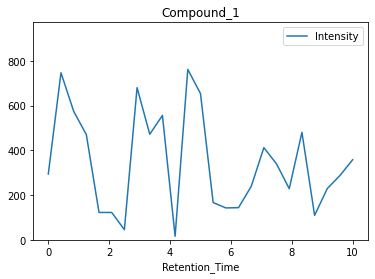

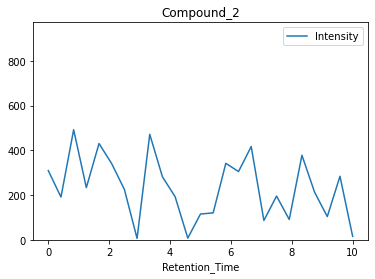

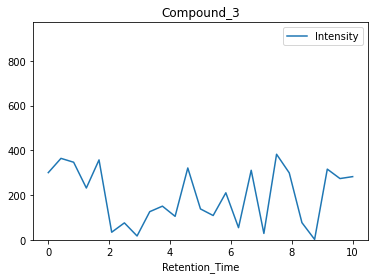

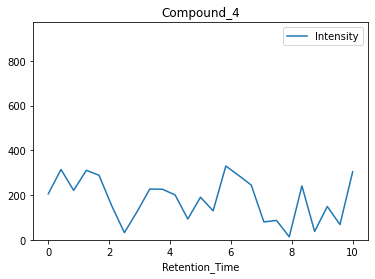

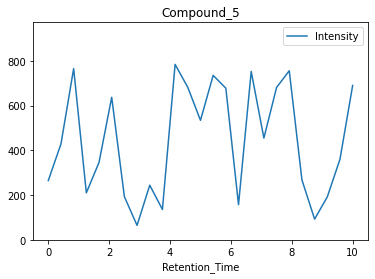

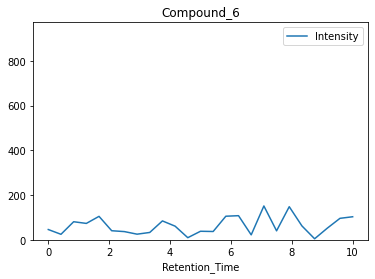

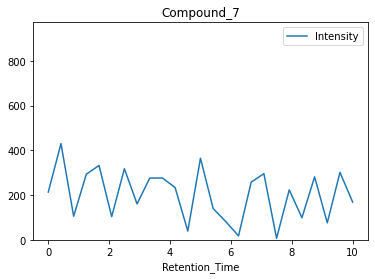

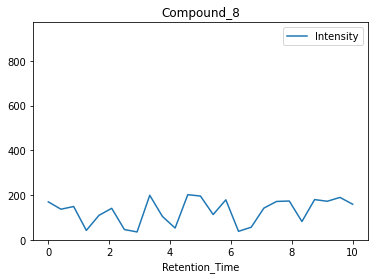

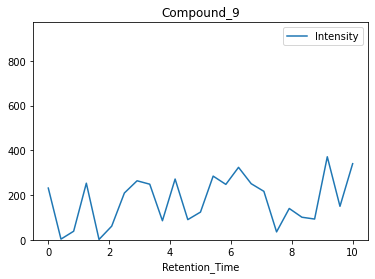

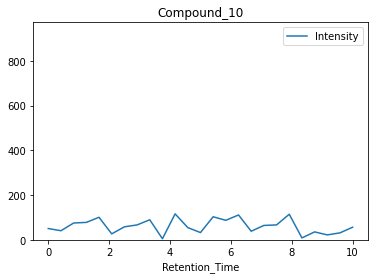

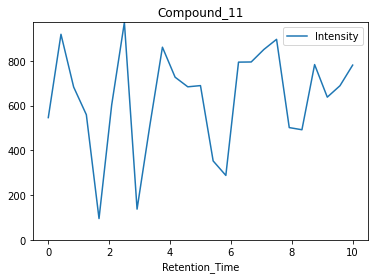

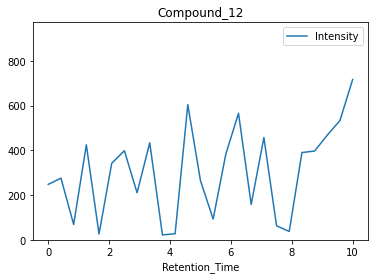

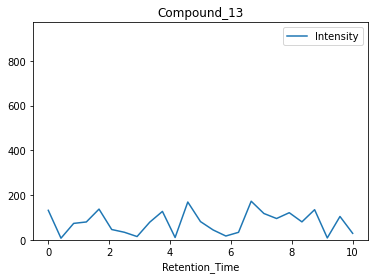

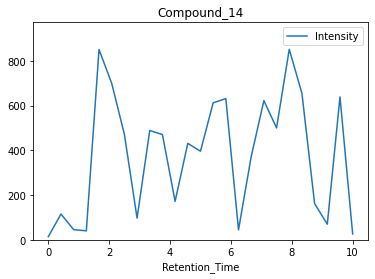

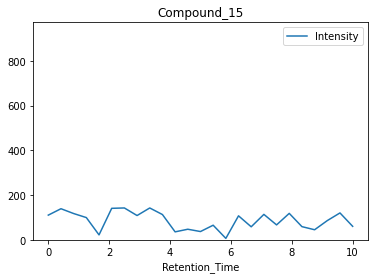

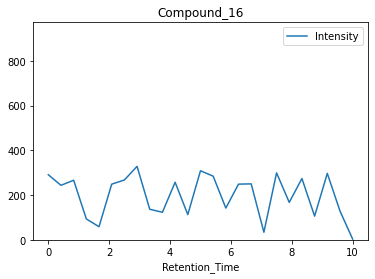

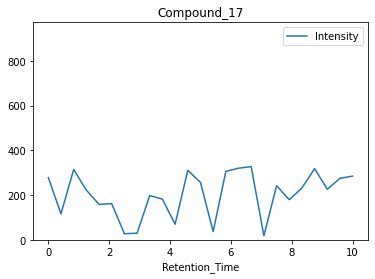

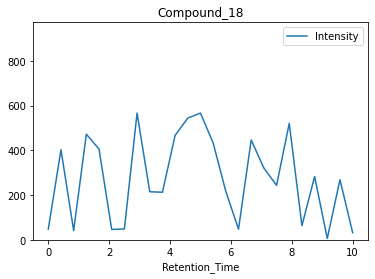

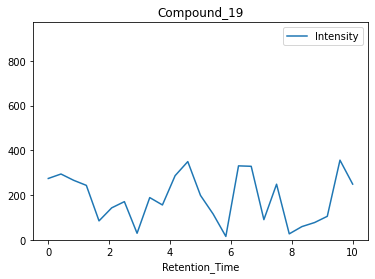

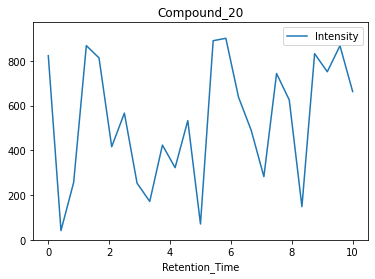

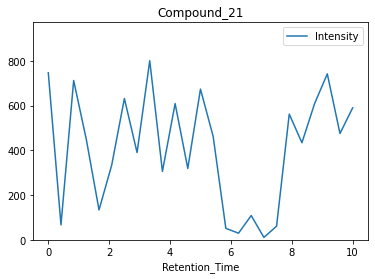

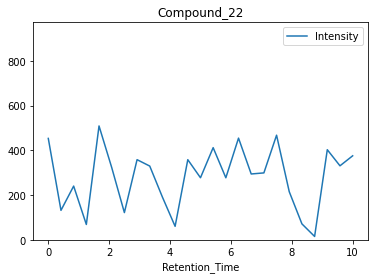

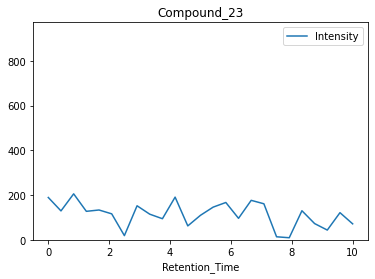

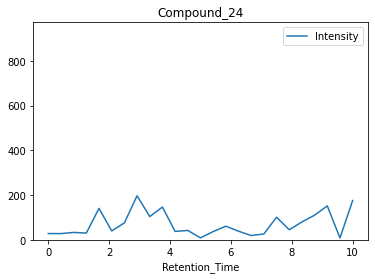

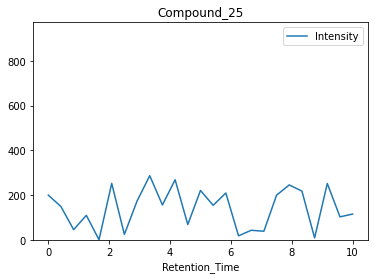

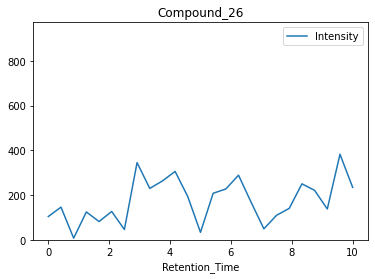

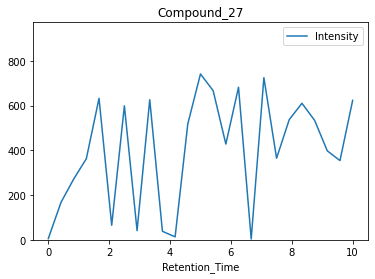

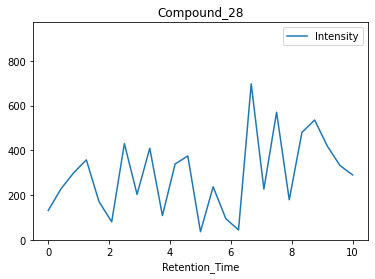

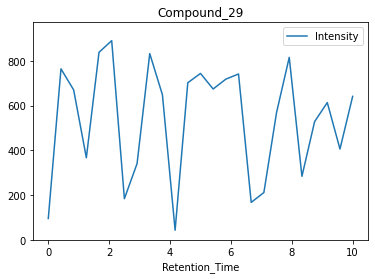

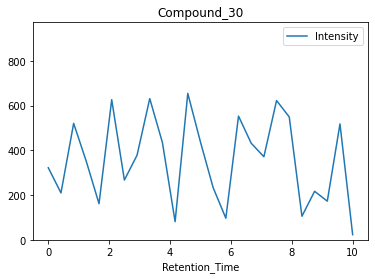

In [9]:
values = np.zeros([25, ])
labels = np.zeros([25, ])
retTime = np.zeros([25, ])
count = 0

#values = cdb_data_source.Intensity
#labels = cdb_data_source.Compound.str[len('Compound_'):].astype(int)
#retTime = cdb_data_source.Retention_Time

print(cdb_data_source[cdb_data_source.columns[0]].unique())

for compound in cdb_data_source[cdb_data_source.columns[0]].unique():
#    print(values.shape, cdb_data_source[cdb_data_source['Compound'] == compound].Intensity.shape)
    values = np.vstack([values, cdb_data_source[cdb_data_source['Compound'] == compound].Intensity])
    labels = np.vstack([labels, cdb_data_source[cdb_data_source['Compound'] == compound].Compound.str[len('Compound_'):].astype(int)])
    retTime = np.vstack([retTime, cdb_data_source[cdb_data_source['Compound'] == compound].Retention_Time])
#    print(compounds[count])
    count += 1
    cdb_data_source[cdb_data_source['Compound'] == compound].plot(x='Retention_Time',title=compound,ylim=[0,cdb_data_source['Intensity'].max()])
    
values = values[1:, :]
labels = labels[1:, :]
retTime = retTime[1:, :]

In [10]:
for compound in cdb_data_source[cdb_data_source.columns[0]].unique():
    display(cdb_data_source[cdb_data_source['Compound'] == compound].describe())

,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,346.467804
std,3.066584,224.181274
min,0.000000,16.179400
25%,2.500000,144.156000
50%,5.000000,294.389000
75%,7.500000,480.916000
max,10.000000,762.349000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,234.352434
std,3.066584,143.935929
min,0.000000,6.645750
25%,2.500000,115.678000
50%,5.000000,225.700000
75%,7.500000,340.834000
max,10.000000,492.599000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,196.883327
std,3.066584,127.597541
min,0.000000,2.142580
25%,2.500000,77.101700
50%,5.000000,210.566000
75%,7.500000,311.252000
max,10.000000,382.912000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,182.813628
std,3.066584,97.395822
min,0.000000,13.747400
25%,2.500000,93.405400
50%,5.000000,201.041000
75%,7.500000,245.388000
max,10.000000,330.382000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,444.684712
std,3.066584,251.362932
min,0.000000,64.971000
25%,2.500000,210.403000
50%,5.000000,429.234000
75%,7.500000,682.054000
max,10.000000,784.665000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,63.906977
std,3.066584,40.483618
min,0.000000,5.023710
25%,2.500000,37.107100
50%,5.000000,52.450800
75%,7.500000,96.421400
max,10.000000,151.657000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,204.178223
std,3.066584,116.138991
min,0.000000,7.248880
25%,2.500000,103.848000
50%,5.000000,223.785000
75%,7.500000,293.723000
max,10.000000,430.729000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,129.885600
std,3.066584,57.192762
min,0.000000,35.515900
25%,2.500000,82.115200
50%,5.000000,142.173000
75%,7.500000,173.834000
max,10.000000,202.240000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,177.831100
std,3.066584,109.657125
min,0.000000,1.933530
25%,2.500000,90.629200
50%,5.000000,209.616000
75%,7.500000,253.458000
max,10.000000,371.690000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,61.618738
std,3.066584,32.852376
min,0.000000,5.101640
25%,2.500000,35.766600
50%,5.000000,58.405600
75%,7.500000,87.483100
max,10.000000,116.362000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,634.336052
std,3.066584,231.126026
min,0.000000,95.427300
25%,2.500000,509.000000
50%,5.000000,684.469000
75%,7.500000,794.793000
max,10.000000,972.233000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,304.714476
std,3.066584,203.560619
min,0.000000,22.417700
25%,2.500000,93.389500
50%,5.000000,342.215000
75%,7.500000,434.262000
max,10.000000,717.251000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,78.306967
std,3.066584,51.797358
min,0.000000,7.597490
25%,2.500000,33.830200
50%,5.000000,80.201300
75%,7.500000,121.566000
max,10.000000,172.904000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,379.550460
std,3.066584,277.456954
min,0.000000,14.321500
25%,2.500000,97.345000
50%,5.000000,431.682000
75%,7.500000,622.731000
max,10.000000,852.207000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,86.816699
std,3.066584,40.887459
min,0.000000,6.779580
25%,2.500000,58.560400
50%,5.000000,99.765900
75%,7.500000,117.827000
max,10.000000,142.791000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,199.225024
std,3.066584,96.500545
min,0.000000,3.598100
25%,2.500000,123.510000
50%,5.000000,249.204000
75%,7.500000,274.384000
max,10.000000,328.848000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,204.009692
std,3.066584,102.791070
min,0.000000,18.381600
25%,2.500000,158.749000
50%,5.000000,226.362000
75%,7.500000,285.200000
max,10.000000,327.661000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,277.130102
std,3.066584,195.586797
min,0.000000,6.528350
25%,2.500000,48.781700
50%,5.000000,269.480000
75%,7.500000,446.859000
max,10.000000,567.318000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,187.853352
std,3.066584,109.065854
min,0.000000,15.537500
25%,2.500000,90.570500
50%,5.000000,189.157000
75%,7.500000,274.656000
max,10.000000,356.508000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,536.060740
std,3.066584,280.840269
min,0.000000,41.538000
25%,2.500000,282.908000
50%,5.000000,566.801000
75%,7.500000,813.701000
max,10.000000,901.397000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,412.701600
std,3.066584,257.817351
min,0.000000,11.115300
25%,2.500000,134.010000
50%,5.000000,448.441000
75%,7.500000,609.677000
max,10.000000,801.038000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,281.929876
std,3.066584,141.018750
min,0.000000,15.369900
25%,2.500000,191.259000
50%,5.000000,299.541000
75%,7.500000,375.979000
max,10.000000,509.463000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,114.435999
std,3.066584,55.715056
min,0.000000,9.630870
25%,2.500000,72.956800
50%,5.000000,121.726000
75%,7.500000,152.543000
max,10.000000,205.897000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,70.907343
std,3.066584,55.047868
min,0.000000,8.648670
25%,2.500000,30.542000
50%,5.000000,42.303600
75%,7.500000,104.272000
max,10.000000,197.293000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,142.643030
std,3.066584,91.804191
min,0.000000,0.755152
25%,2.500000,45.680500
50%,5.000000,154.598000
75%,7.500000,218.138000
max,10.000000,287.001000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,177.327057
std,3.066584,98.992578
min,0.000000,7.787620
25%,2.500000,110.105000
50%,5.000000,167.484000
75%,7.500000,235.041000
max,10.000000,382.768000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,400.755223
std,3.066584,256.101002
min,0.000000,3.943200
25%,2.500000,167.648000
50%,5.000000,428.543000
75%,7.500000,623.905000
max,10.000000,741.958000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,291.402772
std,3.066584,172.932976
min,0.000000,36.535600
25%,2.500000,170.899000
50%,5.000000,290.348000
75%,7.500000,409.773000
max,10.000000,697.922000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,540.037348
std,3.066584,258.136778
min,0.000000,43.237100
25%,2.500000,340.926000
50%,5.000000,641.690000
75%,7.500000,741.794000
max,10.000000,890.846000


,Retention_Time,Intensity
count,25.000000,25.000000
mean,5.000000,359.160104
std,3.066584,194.827451
min,0.000000,23.372100
25%,2.500000,210.060000
50%,5.000000,371.822000
75%,7.500000,521.084000
max,10.000000,655.063000


/home/roadrunner/miniconda3/envs/py3k/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


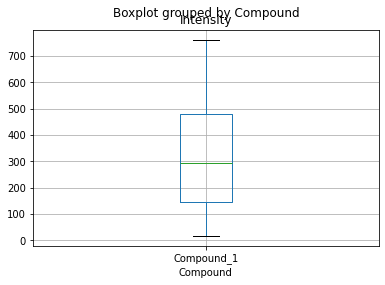

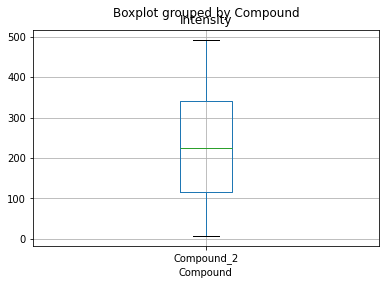

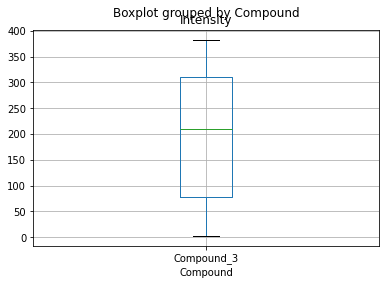

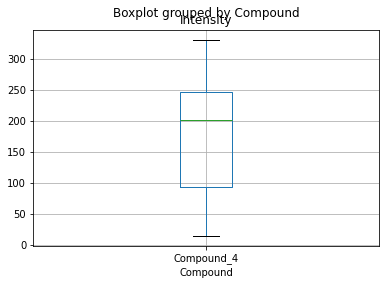

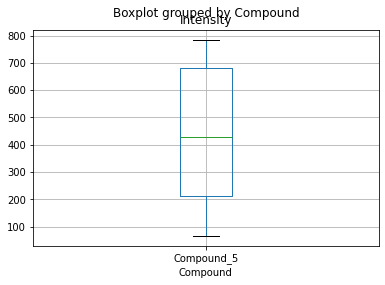

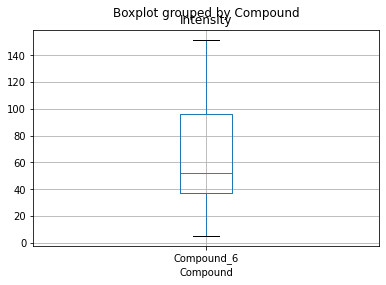

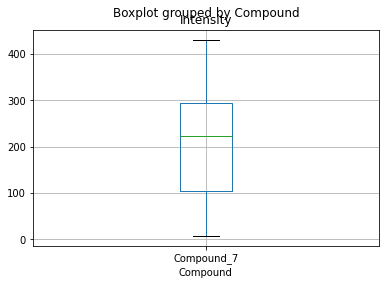

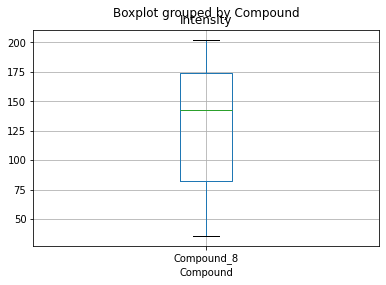

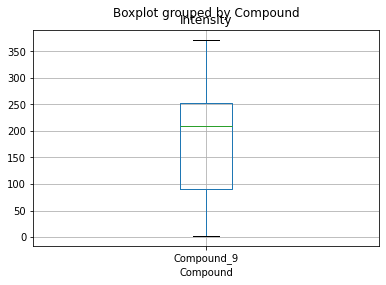

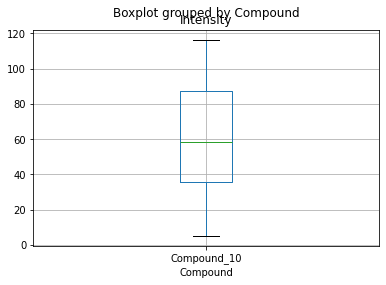

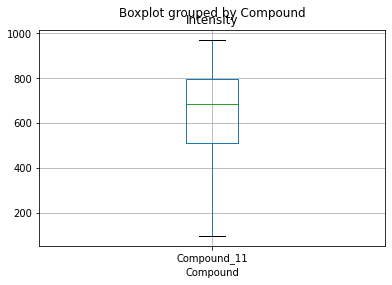

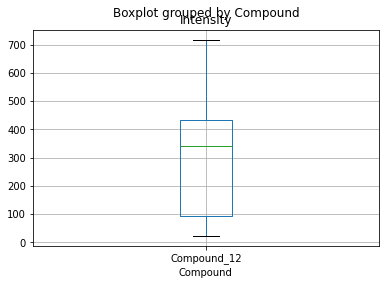

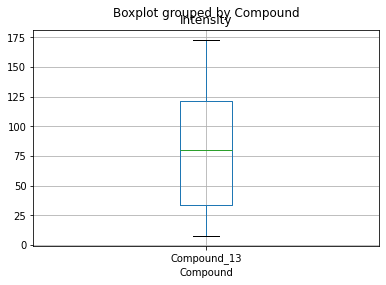

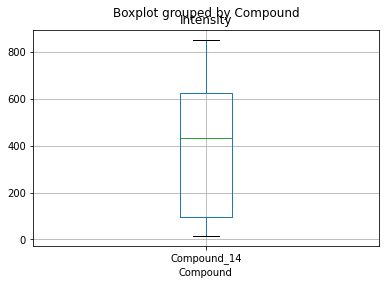

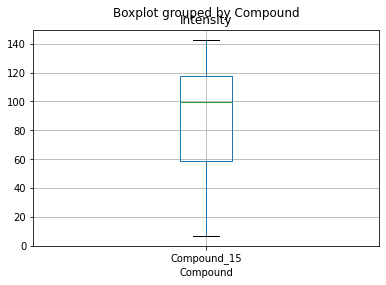

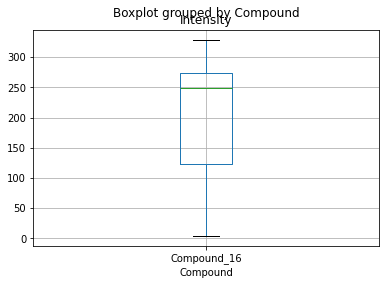

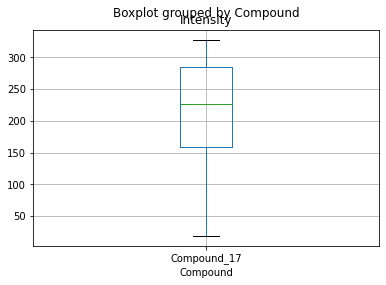

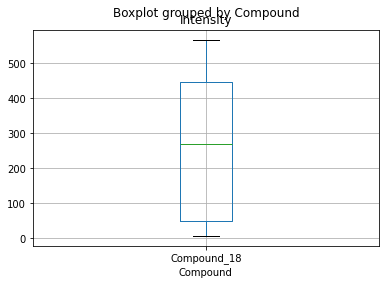

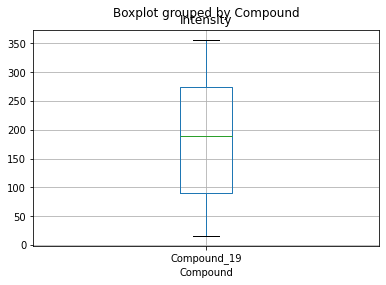

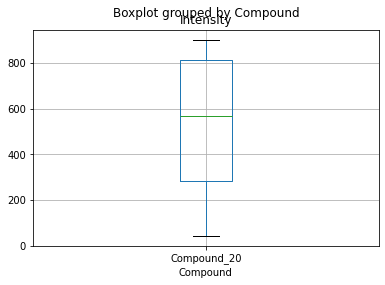

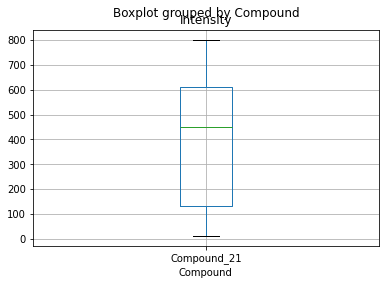

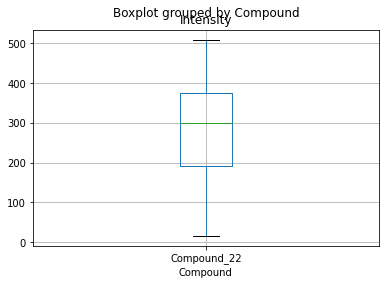

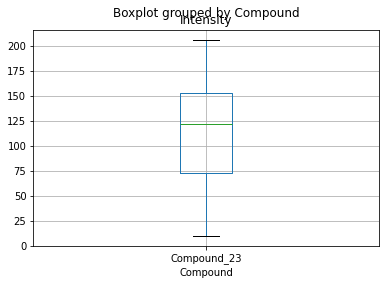

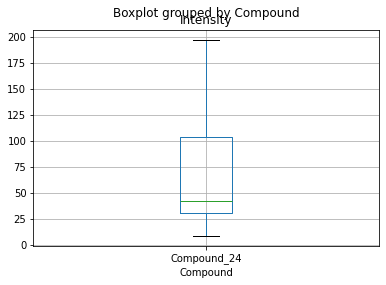

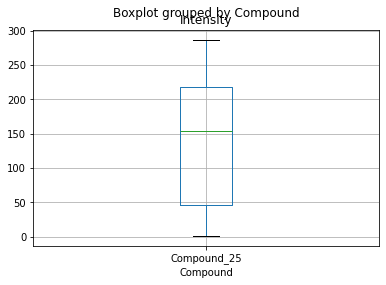

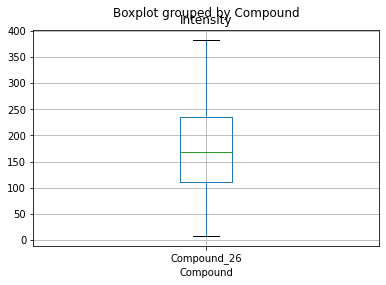

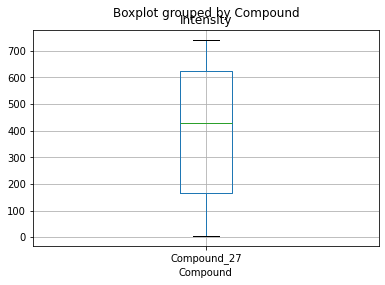

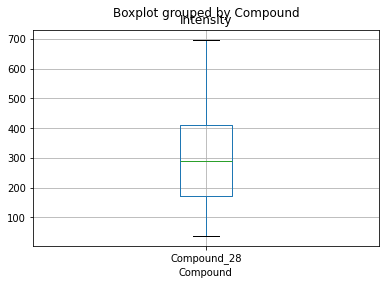

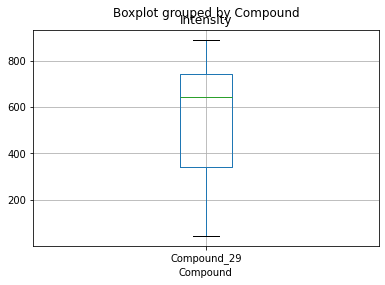

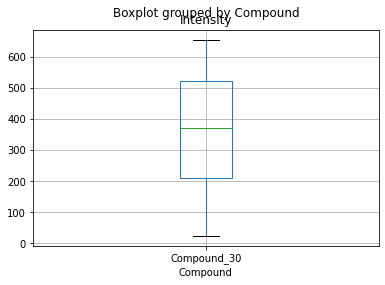

In [11]:
for compound in cdb_data_source[cdb_data_source.columns[0]].unique():
    cdb_data_source[cdb_data_source['Compound'] == compound].boxplot(by='Compound',column=['Intensity'])

In [12]:
from sklearn.metrics import accuracy_score, classification_report
from aeon.classification.deep_learning import CNNClassifier

# normalization doesn't seem to matter...
for count in range(0, values.shape[0]):
    values[count] = (values[count] - values[count].min()) / (values[count].max() - values[count].min())

values_train, values_test, labels_train, labels_test = train_test_split(values, labels, test_size=0.2)

trainset = values_train.reshape(values_train.shape[0], 1, values_train.shape[1])
testset = values_test.reshape(values_test.shape[0], 1, values_test.shape[1])
print(trainset.shape)
print(testset.shape)
print(labels_train[:, 0].shape)
print(labels_test[:, 0].shape)
#print(trainset)

#model = make_model(input_shape=trainset.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)

#trainset = pd.DataFrame({'values': values_train.reshape(1, values_train.shape[0] * values_train.shape[1])[0],
#                        'labels': labels_train.reshape(1, labels_train.shape[0] * labels_train.shape[1])[0]})
#trainset['labels'] = pd.DataFrame(labels_train.reshape(1, labels_train.shape[0] * labels_train.shape[1])[0])
#testset['values'] = pd.DataFrame(values_test.reshape(1, values_test.shape[0] * values_test.shape[1])[0])

opt = "adam"
act = "ReLU"
age = 50
ksz = 10
dbg = False

cnn = CNNClassifier(activation=act, kernel_size=ksz, n_epochs=age, optimizer=opt, verbose=dbg)
print("fitting")
cnn.fit(trainset, labels_train[:, 0])
print("predicting")
y_pred = cnn.predict(testset)


#print(np.vstack((labels_test[:, 0], y_pred)))
#print(classification_report(labels_test[:, 0], y_pred))

print("train    :", np.int64(labels_train[:, 0]))
print("compound :", np.int64(labels_test[:, 0]))
print("predicted:", np.int64(y_pred))

#print(cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(int(labels_test[:, 0][0]))])

(24, 1, 25)
(6, 1, 25)
(24,)
(6,)
fitting
predicting
1/1 [==============================] - 0s 107ms/step
train    : [ 3 27  4 18 21 12 19 13 22 11 23 14 16 15  8  5  6 26 20 24 29  2 17 25]
compound : [ 7 30 28  9 10  1]
predicted: [24 15 29  8  8 15]


Compound on the left looks like Compound on the right


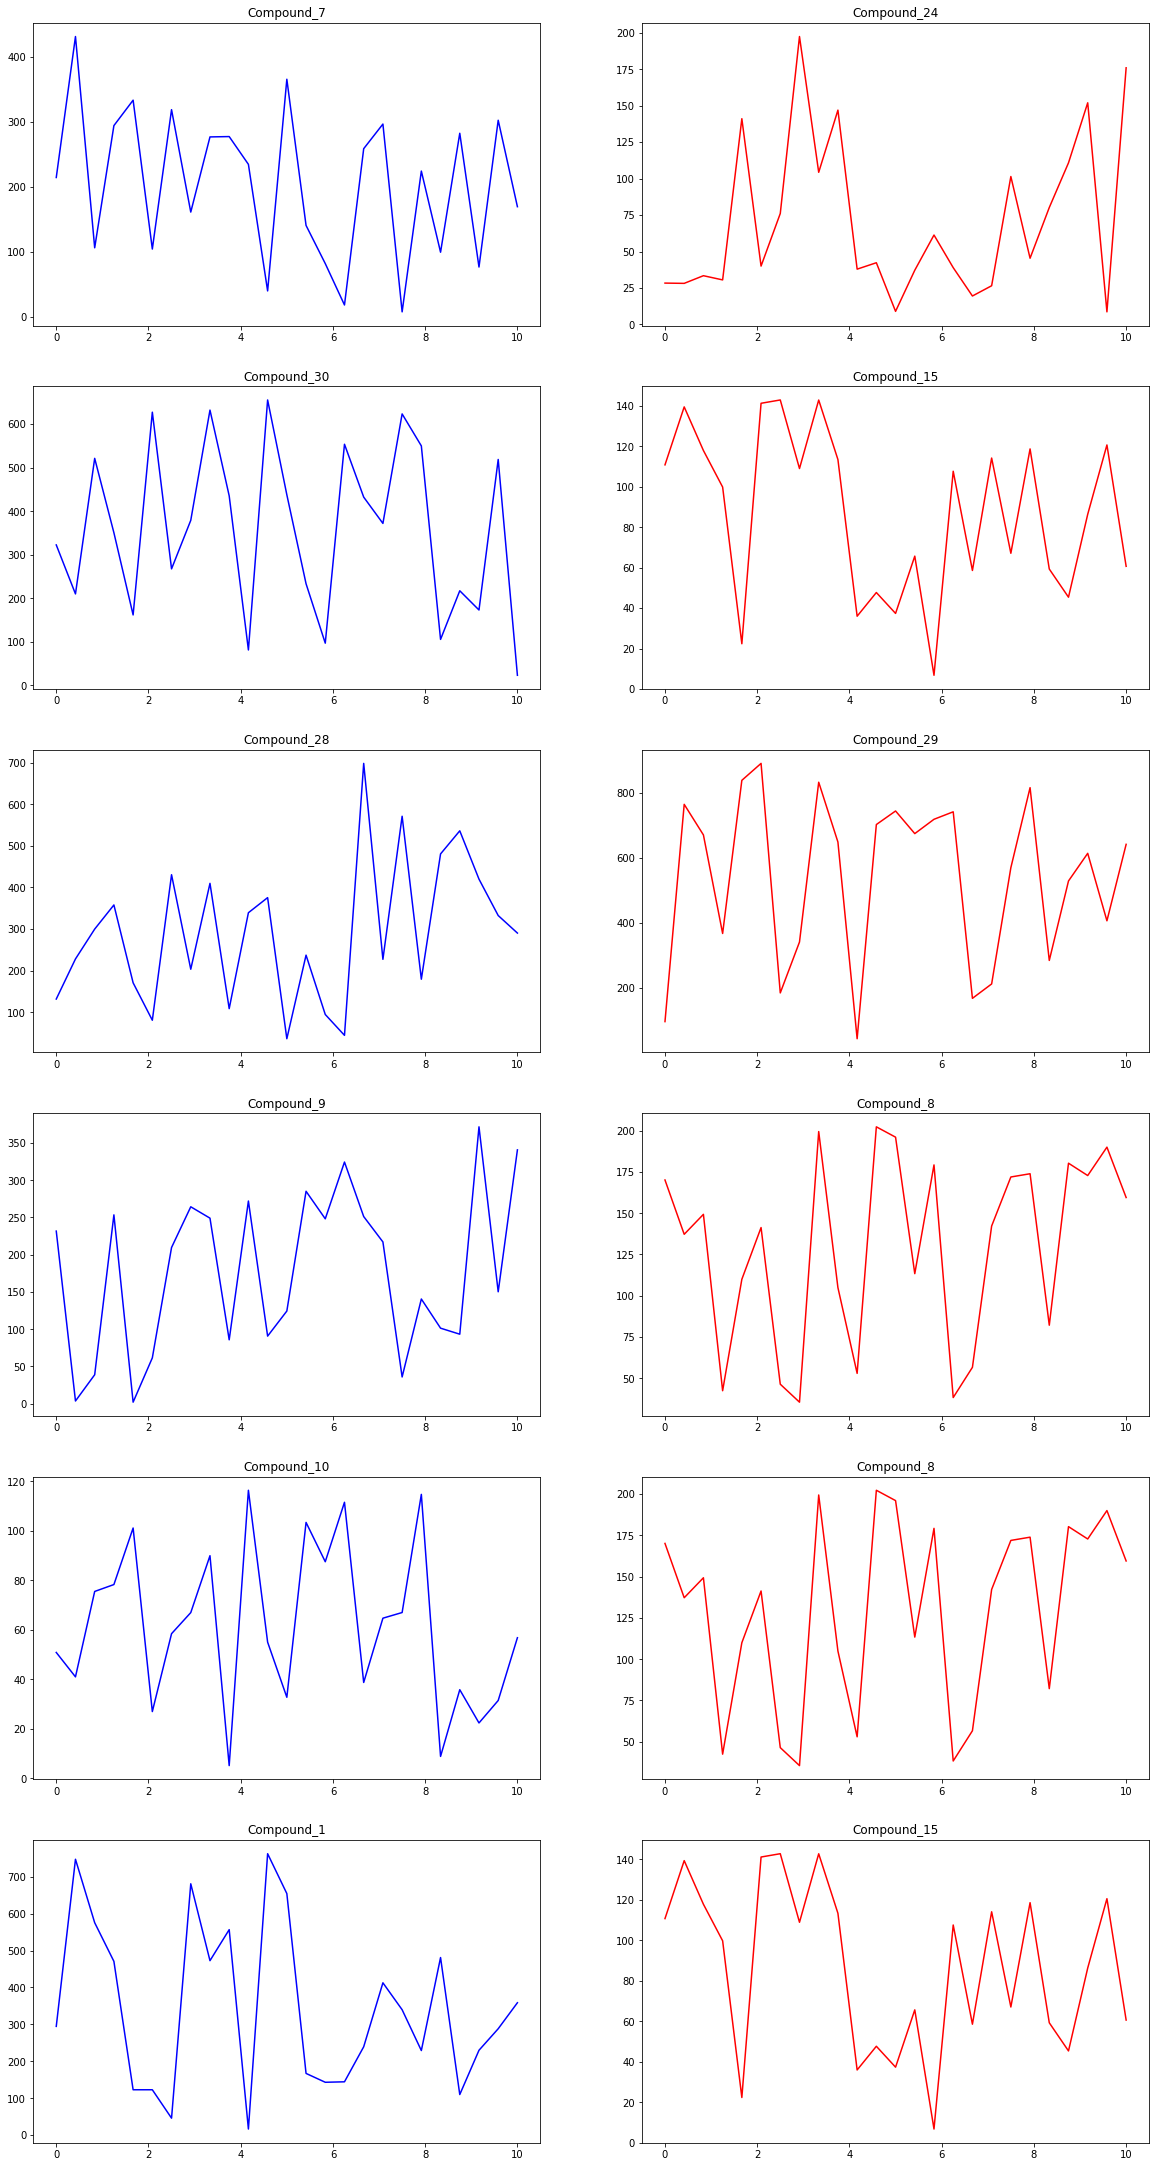

In [28]:
fig, ax = plt.subplots(labels_test[:, 0].shape[0], 2, figsize=(10, 16))
fig.set_size_inches(20, labels_test[:, 0].shape[0] * 6 + 3)

print("Compound on the left looks like Compound on the right")

count = 0
for label in labels_test[:, 0]:
    ax[count][0].set_title("Compound_" + str(int(label)))
    #xrange = range(data[count][val[1]].size)
    #print(cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(int(label))])
    mydata = cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(int(label))][['Retention_Time', 'Intensity']]
    mydata.set_index('Retention_Time', inplace=True)
    yvalues = mydata.Intensity
    ax[count][0].plot(yvalues, data=mydata, color='blue', label="Compound_" + str(int(label)))
 
# plots both curves together
#    mydata = cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(int(y_pred[count]))][['Retention_Time', 'Intensity']]
#    mydata.set_index('Retention_Time', inplace=True)
#    yvalues = mydata.Intensity
#    ax[count][0].plot(yvalues, data=mydata, color='red', label="Compound_" + str(int(y_pred[count])) + " (likeness)")
#    ax[count][0].legend()
    
    count += 1
    
count = 0
for label in y_pred:
    ax[count][1].set_title("Compound_" + str(int(label)))
    mydata = cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(int(label))][['Retention_Time', 'Intensity']]
    mydata.set_index('Retention_Time', inplace=True)
    yvalues = mydata.Intensity
    ax[count][1].plot(yvalues, data=mydata, color='red')
    count += 1

Fold 0:
  Train: index=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[0]
1/1 [==============================] - 0s 19ms/step
max at: 4.58333


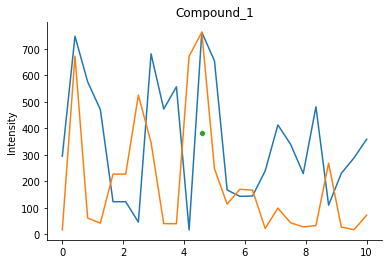

<Figure size 432x288 with 0 Axes>

Fold 1:
  Train: index=[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[1]
1/1 [==============================] - 0s 19ms/step
max at: 2.91667


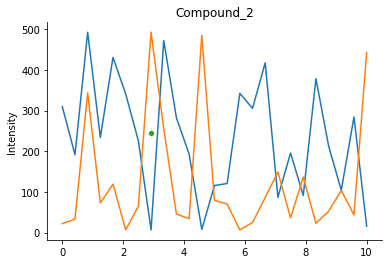

Fold 2:
  Train: index=[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[2]
1/1 [==============================] - 0s 20ms/step
max at: 7.5


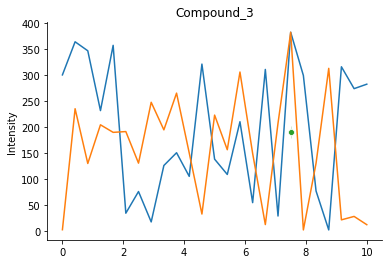

<Figure size 432x288 with 0 Axes>

Fold 3:
  Train: index=[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[3]
1/1 [==============================] - 0s 23ms/step
max at: 7.91667


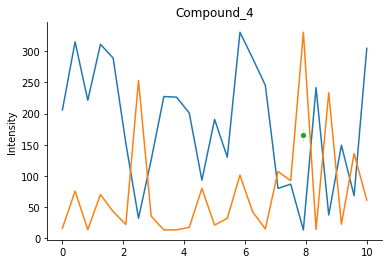

<Figure size 432x288 with 0 Axes>

Fold 4:
  Train: index=[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[4]
1/1 [==============================] - 0s 146ms/step
max at: 2.91667


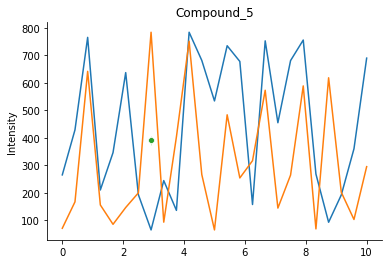

<Figure size 432x288 with 0 Axes>

Fold 5:
  Train: index=[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[5]
1/1 [==============================] - 0s 25ms/step
max at: 7.08333


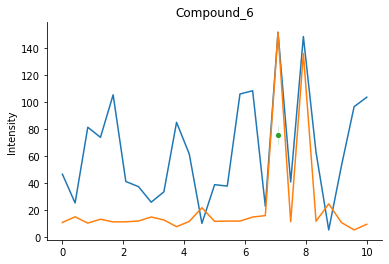

<Figure size 432x288 with 0 Axes>

Fold 6:
  Train: index=[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[6]
1/1 [==============================] - 0s 36ms/step
max at: 0.416667


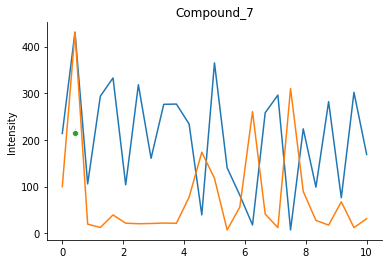

<Figure size 432x288 with 0 Axes>

Fold 7:
  Train: index=[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[7]
1/1 [==============================] - 0s 50ms/step
max at: 4.58333


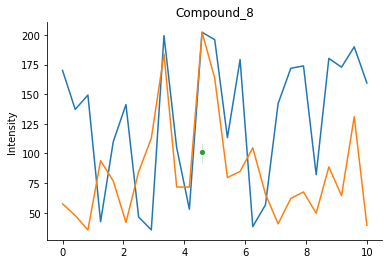

<Figure size 432x288 with 0 Axes>

Fold 8:
  Train: index=[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[8]
1/1 [==============================] - 0s 36ms/step
max at: 9.16667


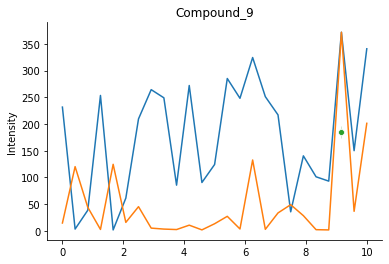

<Figure size 432x288 with 0 Axes>

Fold 9:
  Train: index=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[9]
1/1 [==============================] - 0s 25ms/step
max at: 4.16667


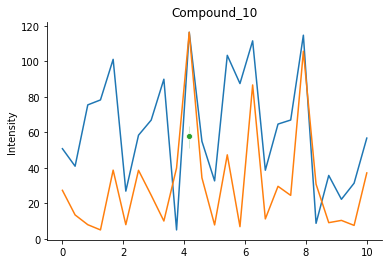

<Figure size 432x288 with 0 Axes>

Fold 10:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[10]
1/1 [==============================] - 0s 26ms/step
max at: 2.5


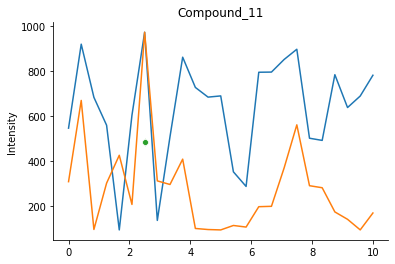

<Figure size 432x288 with 0 Axes>

Fold 11:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[11]
1/1 [==============================] - 0s 33ms/step
max at: 10.0


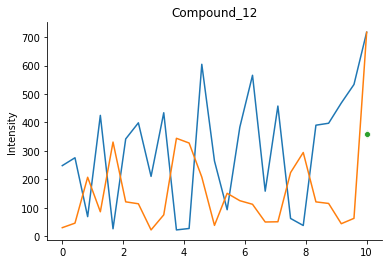

<Figure size 432x288 with 0 Axes>

Fold 12:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[12]
1/1 [==============================] - 0s 21ms/step
max at: 5.0


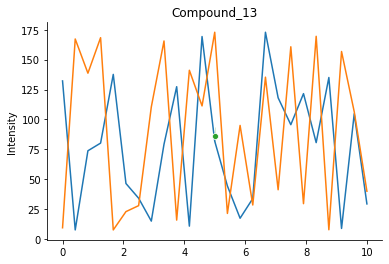

<Figure size 432x288 with 0 Axes>

Fold 13:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[13]
1/1 [==============================] - 0s 21ms/step
max at: 0.0


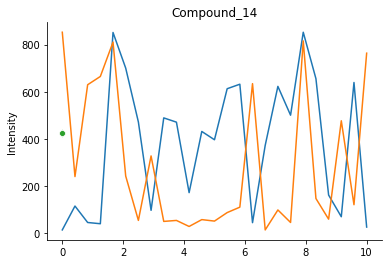

<Figure size 432x288 with 0 Axes>

Fold 14:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[14]
1/1 [==============================] - 0s 21ms/step
max at: 5.83333


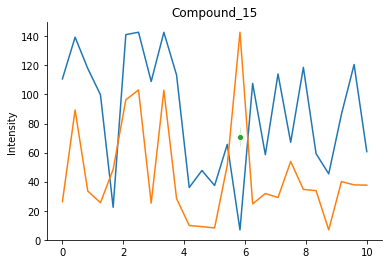

<Figure size 432x288 with 0 Axes>

Fold 15:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[15]
1/1 [==============================] - 0s 21ms/step
max at: 10.0


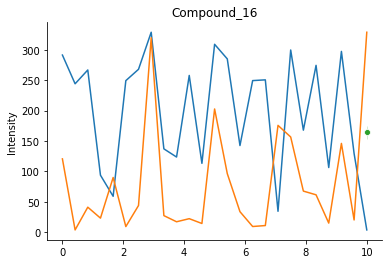

<Figure size 432x288 with 0 Axes>

Fold 16:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[16]
1/1 [==============================] - 0s 132ms/step
max at: 6.66667


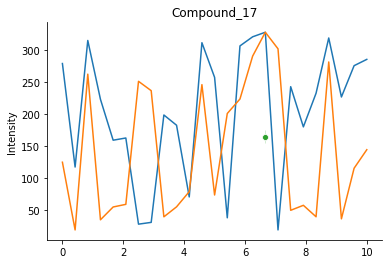

<Figure size 432x288 with 0 Axes>

Fold 17:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[17]
1/1 [==============================] - 0s 20ms/step
max at: 9.16667


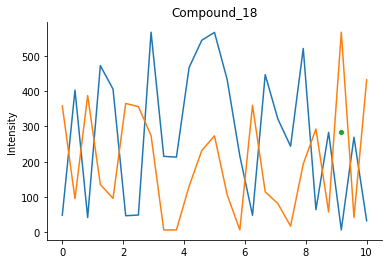

<Figure size 432x288 with 0 Axes>

Fold 18:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[18]
1/1 [==============================] - 0s 27ms/step
max at: 9.58333


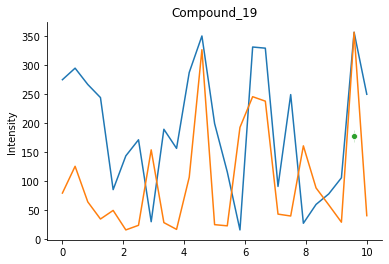

<Figure size 432x288 with 0 Axes>

Fold 19:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29]
  Test:  index=[19]
1/1 [==============================] - 0s 19ms/step
max at: 5.83333


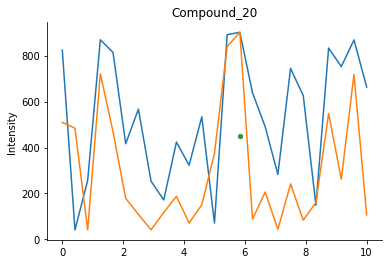

<Figure size 432x288 with 0 Axes>

Fold 20:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29]
  Test:  index=[20]
1/1 [==============================] - 0s 19ms/step
max at: 7.08333


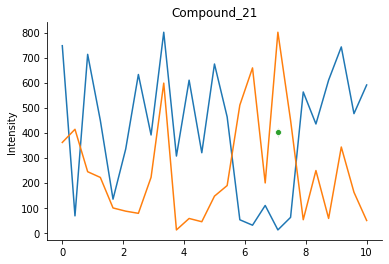

<Figure size 432x288 with 0 Axes>

Fold 21:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29]
  Test:  index=[21]
1/1 [==============================] - 0s 19ms/step
max at: 1.66667


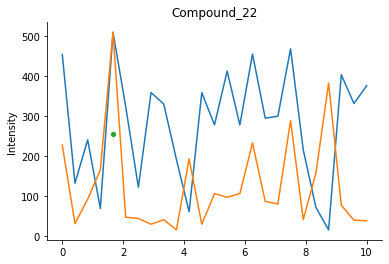

<Figure size 432x288 with 0 Axes>

Fold 22:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29]
  Test:  index=[22]
1/1 [==============================] - 0s 32ms/step
max at: 7.91667


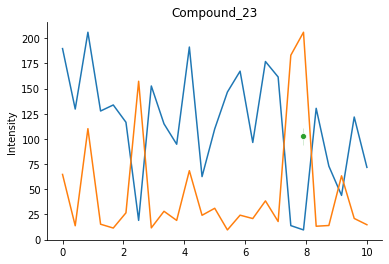

<Figure size 432x288 with 0 Axes>

Fold 23:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29]
  Test:  index=[23]
1/1 [==============================] - 0s 21ms/step
max at: 9.58333


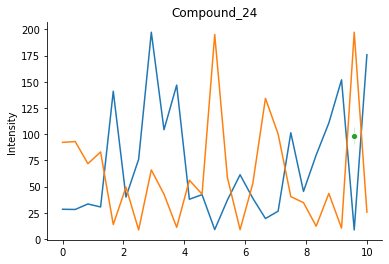

<Figure size 432x288 with 0 Axes>

Fold 24:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29]
  Test:  index=[24]
1/1 [==============================] - 0s 33ms/step
max at: 3.33333


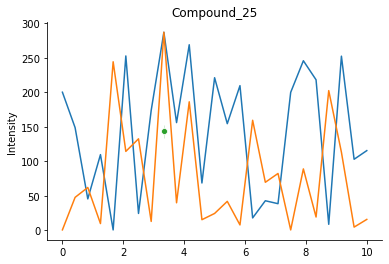

<Figure size 432x288 with 0 Axes>

Fold 25:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29]
  Test:  index=[25]
1/1 [==============================] - 0s 20ms/step
max at: 9.58333


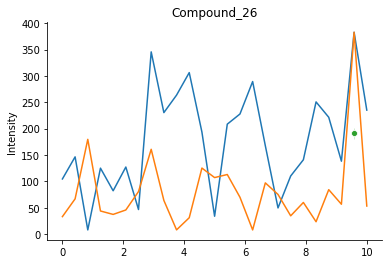

<Figure size 432x288 with 0 Axes>

Fold 26:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29]
  Test:  index=[26]
1/1 [==============================] - 0s 20ms/step
max at: 5.0


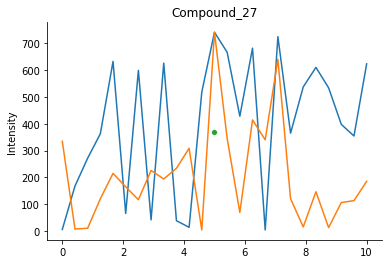

<Figure size 432x288 with 0 Axes>

Fold 27:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29]
  Test:  index=[27]
1/1 [==============================] - 0s 18ms/step
max at: 5.0


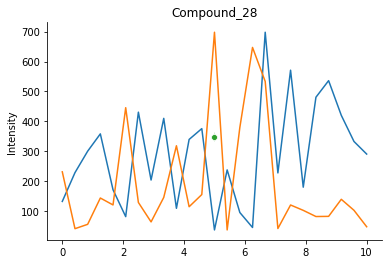

<Figure size 432x288 with 0 Axes>

Fold 28:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29]
  Test:  index=[28]
1/1 [==============================] - 0s 20ms/step
max at: 4.16667


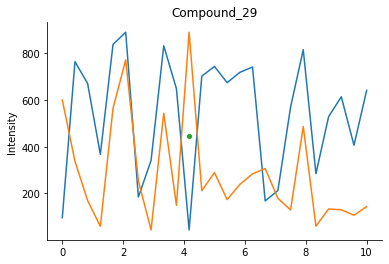

<Figure size 432x288 with 0 Axes>

Fold 29:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
  Test:  index=[29]
1/1 [==============================] - 0s 21ms/step
max at: 10.0


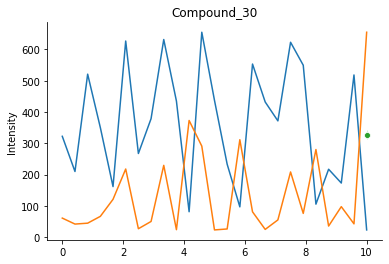

<Figure size 432x288 with 0 Axes>

In [119]:
def sliding_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_classifier(selection):
    if selection == "LOF":
        return LOF(n_neighbors=21, algorithm='kd_tree', 
            leaf_size=10, metric='euclidean', 
            p=2, metric_params=None, contamination=0.001, 
            n_jobs=-1, novelty=True)
    elif selection == "DeepSVDD":
        return DeepSVDD(verbose=0)

#print(np.repeat(sliding_window(values_test[0], 1), 25, axis=1))
#print(np.repeat(sliding_window(values[0], 1), 25, axis=1))
#print(values_test[0])
#print(values[0])
#print(LeaveOneOut().get_n_splits(values_test))

for count, (train_index, test_index) in enumerate(LeaveOneOut().split(values)):
    print(f"Fold {count}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

#    clf = LOF(n_neighbors=21, algorithm='kd_tree', 
#            leaf_size=10, metric='euclidean', 
#            p=2, metric_params=None, contamination=0.001, 
#            n_jobs=-1, novelty=True)
#    clf = DeepSVDD(verbose=0)
    clf = get_classifier('DeepSVDD')
    clf.fit(values[train_index])
    score = clf.decision_function(np.repeat(values[test_index].reshape(-1, 1), 25, axis=1))
    print("max at:", retTime[count][score.argmax()])
    #sns.lineplot(x=retTime[count], y=values[test_index].flatten())
    sns.lineplot(x=retTime[count], y=cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(count + 1)].Intensity)
    val_max = cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(count + 1)].Intensity.max()
    val_min = cdb_data_source[cdb_data_source['Compound'] == "Compound_" + str(count + 1)].Intensity.min()
    score = val_min + ((score - score.min()) * (val_max - val_min)) / (score.max() - score.min())
    sns.lineplot(x=retTime[count], y=score)
    sns.lineplot(x=retTime[count][score.argmax()], y=np.arange(val_max), lw=2, marker='o')
    sns.despine()
    plt.title("Compound_" + str(count + 1))
    plt.figure(count)
    plt.show()

#clf = LOF(n_neighbors=21, algorithm='kd_tree', 
#            leaf_size=10, metric='euclidean', 
#            p=2, metric_params=None, contamination=(1/(data.shape[-1]-test_start)), 
#            p=2, metric_params=None, contamination=0.001, 
#            n_jobs=-1, novelty=True)
#clf.fit(values_train)

#print(sliding_window(values_test[0], 1))
#print(np.repeat(sliding_window(values_test[0], 1), 25, axis=1))
#score = clf.decision_function(np.repeat(sliding_window(values_test[0], 1), 25, axis=1))

#print(score)

#sns.lineplot(x=np.arange(25), y=values_test[0])
#sns.lineplot(x=np.arange(25), y=score)